Use the autoreload extension to automatically reload modified Python code without restarting the notebook.

In [ ]:
%load_ext autoreload
%autoreload 2

# Import own python_modules here and modifications on these will take effect without reloading explicitly

In [ ]:
#import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm  # Progress bar to check remaining time for processes

!pip install langdetect
from langdetect import detect # Language detection for texts

import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

from joblib import dump


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# BoardGameGeek 19 million reviews study

Source: https://www.kaggle.com/datasets/jvanelteren/boardgamegeek-reviews/

<b>The file we are looking at is bgg-19m-reviews.csv<b>

## Aim: Sentiment analysis of review comments

Pipeline of a machine learning study:

- loading data
- describing data, discrete/continuous, categorical/not categorical
- data cleaning (eliminating NaNs), converting text data to numeric values, removing duplicate rows
- basic distributions of features, correlation matrix
- data analysis with diagrams:
    - histograms
    - paired histograms
    - ratio for categorical data: pie chart
    - analysis along at least two dimensions: scatter plot
    - box plots

- data normalization
- training machine learning models
- evaluation of the results:
    - accuracy, confusion matrix in more dimension
    - ROCAUC curve
    - PPV, NPV (positive predictive value, in binary classification)

# Exploratory Data Analysis

In [ ]:
# Loading the data

data_path = "/content/drive/MyDrive/Mathematical Modeling Practice/bgg-19m-reviews.csv"
df = pd.read_csv(data_path)
df.head()

,Unnamed: 0,user,rating,comment,ID,name
0,0,Torsten,10.0,NaN,30549,Pandemic
1,1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
3,3,Mike Mayer,10.0,NaN,30549,Pandemic
4,4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic


## Variables

Unnamed: 0 - Indices

### Categorical

N/A - but we can transform the ratings to be categorical.

### Not categorical

user - Name of the user who rated the game.

rating - Numerical rating of the game.

comment - The review comment as a String.

ID - The game's ID.

name - The name of the game as a String.



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18964807 entries, 0 to 18964806
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   user        object 
 2   rating      float64
 3   comment     object 
 4   ID          int64  
 5   name        object 
dtypes: float64(1), int64(2), object(3)
memory usage: 868.1+ MB


In [ ]:
df.describe()

,Unnamed: 0,rating,ID
count,1.896481e+07,1.896481e+07,1.896481e+07
mean,9.482403e+06,7.081849e+00,1.101461e+05
std,5.474668e+06,1.595931e+00,9.309589e+04
min,0.000000e+00,1.401300e-45,1.000000e+00
25%,4.741202e+06,6.000000e+00,1.598700e+04
50%,9.482403e+06,7.000000e+00,1.075290e+05
75%,1.422360e+07,8.000000e+00,1.813040e+05
max,1.896481e+07,1.000000e+01,3.509920e+05


## Missing Data

For the sentiment analysis we are only interested in comments and ratings, where the comments are our features and the ratings are the targets.

Based on this all the rows should be dropped, where the comments are missing.

In [ ]:
df.isna().sum()

Unnamed: 0           0
user                66
rating               0
comment       15596188
ID                   0
name                 0
dtype: int64

In [ ]:
(df == 0).sum()

Unnamed: 0    1
user          0
rating        0
comment       0
ID            0
name          0
dtype: int64

In [ ]:
print(df.shape)

(18964807, 6)


In [ ]:
df.dropna(subset = ['comment'], inplace=True)

In [ ]:
# Dropped 15596188 rows with empty comments from a total of 18964807 rows
18964807 - 15596188

3368619

In [ ]:
print(df.shape)

(3368619, 6)


In [ ]:
df.isna().sum()

Unnamed: 0    0
user          0
rating        0
comment       0
ID            0
name          0
dtype: int64

In [ ]:
(df == 0).sum()

Unnamed: 0    0
user          0
rating        0
comment       0
ID            0
name          0
dtype: int64

In [ ]:
df.head()

,Unnamed: 0,user,rating,comment,ID,name
1,1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
4,4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic
5,5,cfarrell,10.0,Hey! I can finally rate this game I've been pl...,30549,Pandemic
8,8,gregd,10.0,Love it- great fun with my son. 2 plays so far...,30549,Pandemic


In [ ]:
df.tail()

,Unnamed: 0,user,rating,comment,ID,name
18964798,18964798,Peter The Rat,4.0,"Sadly, to slow moving and fiddly!",1752,Haps
18964800,18964800,spellengek,4.0,"Weird card game with some nice gameplay, but a...",1752,Haps
18964803,18964803,Gregarius,2.0,"I hated this game. Too complicated to set up, ...",1752,Haps
18964804,18964804,Lajos,2.0,Sold in Geekauction for 3 GG.,1752,Haps
18964805,18964805,Imagine,1.0,This game is not for me - I just didn&#039;t g...,1752,Haps


In [ ]:
# Example comment
print(df.loc[1]['comment'])

Hands down my favorite new game of BGG CON 2007.  We played it 5 times in a row -- it's just that good.  Too bad Pandemic won't be in stores until January of 2008.  If you like pure coöp games (Lord of the Rings, Feurio, etc.), this should be right up your alley.  Having 5 roles to choose from gives the game some extra variability.  Also, once you get good you can ramp up the difficulty by adding more Epidemic cards.  9 -> 10


## Unneccesary data

As mentioned above, we are only interested in the ratings and the comments and for further evaluation we would also like to keep the name column. We drop all other columns.

In [ ]:
df.drop(columns=['Unnamed: 0', 'user', 'ID'], inplace=True)

In [ ]:
print(df.shape)

(3368619, 3)


In [ ]:
df.head()

,rating,comment,name
1,10.0,Hands down my favorite new game of BGG CON 200...,Pandemic
2,10.0,I tend to either love or easily tire of co-op ...,Pandemic
4,10.0,This is an amazing co-op game. I play mostly ...,Pandemic
5,10.0,Hey! I can finally rate this game I've been pl...,Pandemic
8,10.0,Love it- great fun with my son. 2 plays so far...,Pandemic


In [ ]:
df.describe()

,rating
count,3.368619e+06
mean,6.905662e+00
std,1.785285e+00
min,1.401300e-45
25%,6.000000e+00
50%,7.000000e+00
75%,8.000000e+00
max,1.000000e+01


In [ ]:
df.isna().sum()

rating     0
comment    0
name       0
dtype: int64

In [ ]:
(df == 0).sum()

rating     0
comment    0
name       0
dtype: int64

## Save the partially cleaned data for further processing

In [ ]:
df.to_csv('/content/drive/MyDrive/Mathematical Modeling Practice/ratings_reviews_cleaned.csv', index=False, encoding='utf-8')

In [ ]:
# Check that the save was successful
data_path = "/content/drive/MyDrive/Mathematical Modeling Practice/ratings_reviews_cleaned.csv"
df = pd.read_csv(data_path)
df.head()

,rating,comment,name
0,10.0,Hands down my favorite new game of BGG CON 200...,Pandemic
1,10.0,I tend to either love or easily tire of co-op ...,Pandemic
2,10.0,This is an amazing co-op game. I play mostly ...,Pandemic
3,10.0,Hey! I can finally rate this game I've been pl...,Pandemic
4,10.0,Love it- great fun with my son. 2 plays so far...,Pandemic


In [ ]:
print(df.shape)

(3368619, 3)


## Ratings

Let's further investigate the distribution of the ratings!

In [ ]:
df['rating'].describe()

count    3.368619e+06
mean     6.905662e+00
std      1.785285e+00
min      1.401300e-45
25%      6.000000e+00
50%      7.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [ ]:
df.rating.value_counts(sort=True)

7.000    666534
8.000    561700
6.000    488604
9.000    290777
5.000    260653
          ...  
9.447         1
9.521         1
9.257         1
9.471         1
2.165         1
Name: rating, Length: 4795, dtype: int64

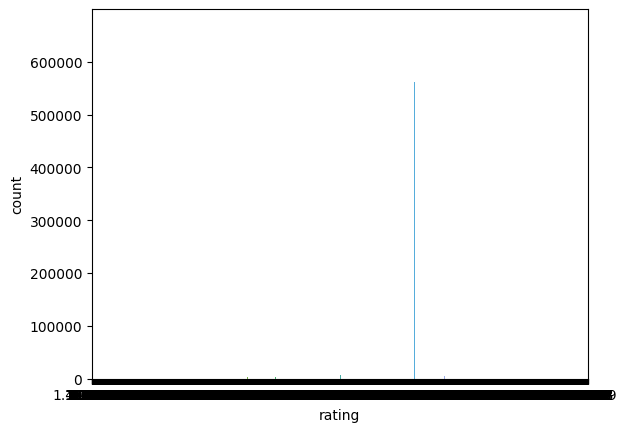

In [ ]:
sns.countplot(x="rating", data=df)
plt.show()

With sns.countplot() the plot is not so easy to read, let's also plot a hist plot with 100 bins.

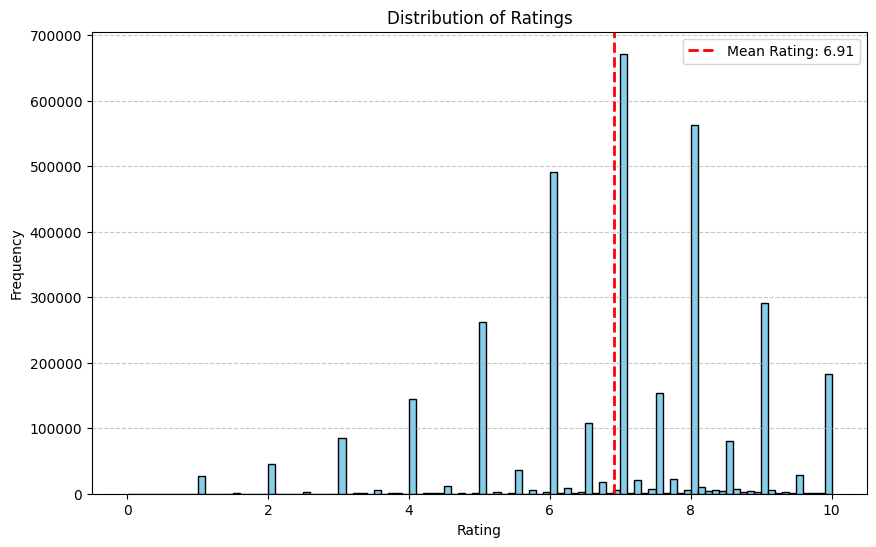

In [ ]:
# Calculate the mean of ratings
mean_rating = df['rating'].mean()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=100, color='skyblue', edgecolor='black')

# Add a vertical line for the mean
plt.axvline(mean_rating, color='red', linestyle='dashed', linewidth=2, label=f'Mean Rating: {mean_rating:.2f}')

plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


The rating values seem highly unbalanced, lets try to round the values and go from continuous to categorical.

In [ ]:
df['rating'] = df.rating.apply(lambda x: round(x))

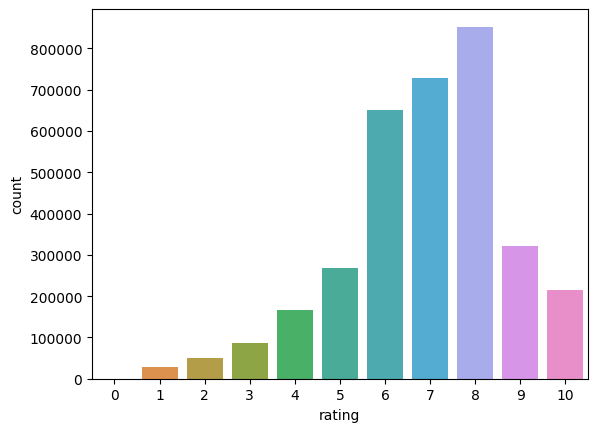

In [ ]:
sns.countplot(x="rating", data=df)
plt.show()

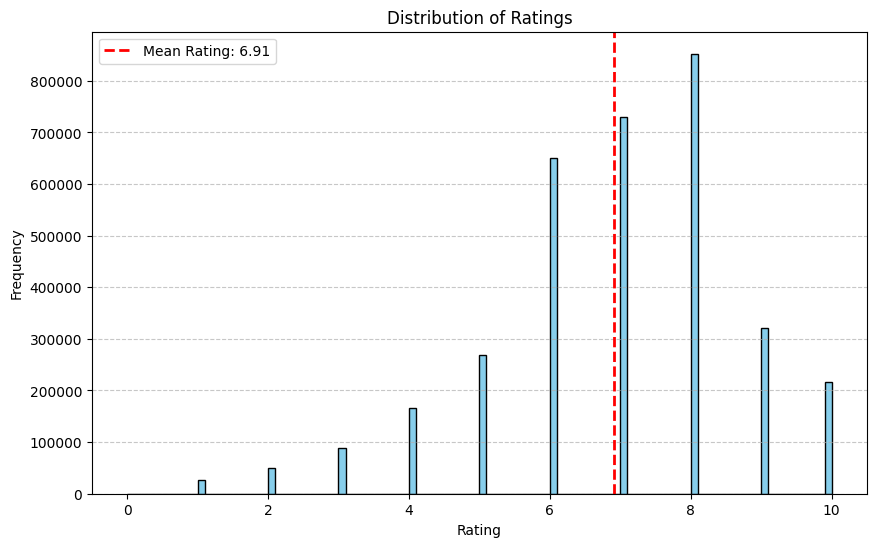

In [ ]:
# Calculate the mean of ratings
mean_rating = df['rating'].mean()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=100, color='skyblue', edgecolor='black')

# Add a vertical line for the mean
plt.axvline(mean_rating, color='red', linestyle='dashed', linewidth=2, label=f'Mean Rating: {mean_rating:.2f}')

plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


## Comments

Let's also investigate the comments!

In [ ]:
# Calculate comment length for each comment
df['comment_length'] = df['comment'].apply(len)

print(df['comment_length'].describe())

count    3.368619e+06
mean     2.110535e+02
std      3.462992e+02
min      1.000000e+00
25%      4.700000e+01
50%      1.160000e+02
75%      2.450000e+02
max      2.811100e+04
Name: comment_length, dtype: float64


In [ ]:
df.comment_length.value_counts(sort=True)

11      29023
3       27182
1       26245
4       24299
7       21868
        ...  
7954        1
4076        1
5009        1
9852        1
7357        1
Name: comment_length, Length: 5921, dtype: int64

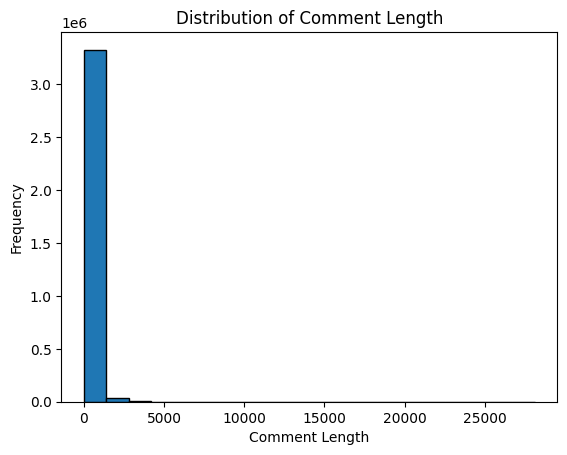

In [ ]:
# Plot histogram of comment length
plt.hist(df['comment_length'], bins=20, edgecolor='black')
plt.title('Distribution of Comment Length')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()

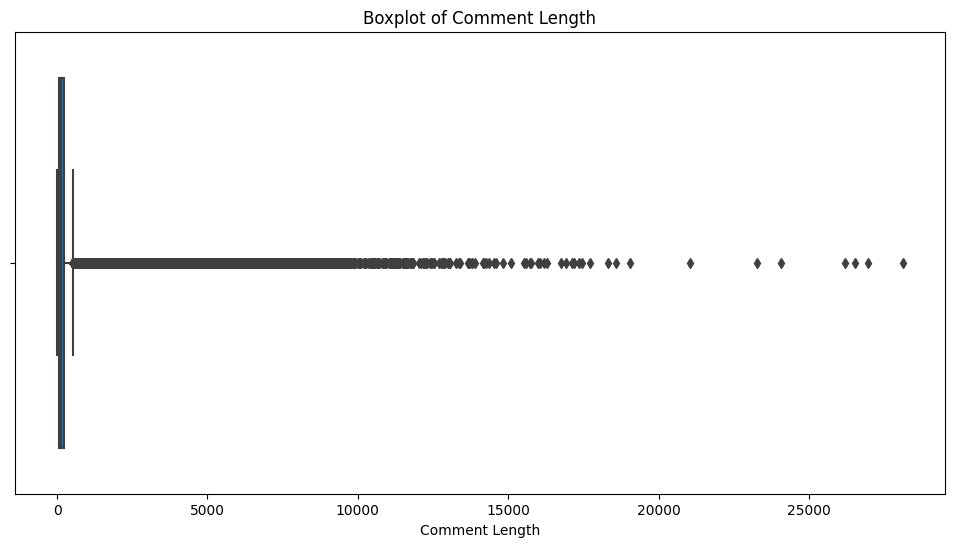

In [ ]:
# Visualize the distribution of comment length with a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['comment_length'])
plt.title('Boxplot of Comment Length')
plt.xlabel('Comment Length')
plt.show()

In [ ]:
df.head()

,rating,comment,name,comment_length
0,10,Hands down my favorite new game of BGG CON 200...,Pandemic,429
1,10,I tend to either love or easily tire of co-op ...,Pandemic,406
2,10,This is an amazing co-op game. I play mostly ...,Pandemic,316
3,10,Hey! I can finally rate this game I've been pl...,Pandemic,1235
4,10,Love it- great fun with my son. 2 plays so far...,Pandemic,75


Before doing any further processing, let's also drop the duplicates! This way we can lessen the computation cost.

In [ ]:
df.shape

(3368619, 4)

In [ ]:
# First drop the comment_length column, as we only needed that for visualisation.
df.drop(columns=['comment_length'], inplace=True)

In [ ]:
df.head()

,rating,comment,name
0,10,Hands down my favorite new game of BGG CON 200...,Pandemic
1,10,I tend to either love or easily tire of co-op ...,Pandemic
2,10,This is an amazing co-op game. I play mostly ...,Pandemic
3,10,Hey! I can finally rate this game I've been pl...,Pandemic
4,10,Love it- great fun with my son. 2 plays so far...,Pandemic


In [ ]:
df.shape

(3368619, 3)

In [ ]:
# When dropping duplicates, we don't care about the board game's name
df.drop_duplicates(subset=['rating', 'comment'], inplace=True)

In [ ]:
df.shape

(3115466, 3)

In [ ]:
df.to_csv('/content/drive/MyDrive/Mathematical Modeling Practice/ratings_reviews_pre_lang.csv', index=False, encoding='utf-8')

In [ ]:
# Check that the save was successful
data_path = "/content/drive/MyDrive/Mathematical Modeling Practice/ratings_reviews_pre_lang.csv"
df = pd.read_csv(data_path)
df.head()

,rating,comment,name
0,10,Hands down my favorite new game of BGG CON 200...,Pandemic
1,10,I tend to either love or easily tire of co-op ...,Pandemic
2,10,This is an amazing co-op game. I play mostly ...,Pandemic
3,10,Hey! I can finally rate this game I've been pl...,Pandemic
4,10,Love it- great fun with my son. 2 plays so far...,Pandemic


In [ ]:
df.shape

(3115466, 3)

Now comes the processing heavy part, let's detect the language each comment was written in!

In [ ]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# Apply language detection to comments with progress bar
tqdm.pandas(desc="Detecting Language")
df['language'] = df['comment'].progress_apply(detect_language)

print(df['language'].value_counts())

# Save the new dataset as a checkpoint
df.to_csv('/content/drive/MyDrive/Mathematical Modeling Practice/ratings_reviews_cleaned_languages.csv', index=False, encoding='utf-8')

Detecting Language:   0%|          | 0/3115466 [00:00<?, ?it/s]

en         2786489
es           49936
de           38326
fr           30550
unknown      18917
it           16538
hu           14073
ko           13013
da           12163
nl           11910
pt           11199
pl           10487
ca            9561
af            9428
no            8967
tl            7850
ro            6300
sv            6091
cy            5674
so            5470
id            4944
ja            3964
ru            3932
et            3541
sw            3281
zh-cn         3275
zh-tw         2638
fi            2365
vi            2339
sl            1857
tr            1609
lt            1515
hr            1250
sk            1120
el            1057
sq            1037
cs             829
th             506
lv             485
bg             473
uk             249
mk             120
he             106
ar              16
fa              15
ur               1
Name: language, dtype: int64


## Further cleaning

In [ ]:
# Check that the save was successful
data_path = "/content/drive/MyDrive/Mathematical Modeling Practice/ratings_reviews_cleaned_languages.csv"
df = pd.read_csv(data_path)
df.head()

,rating,comment,name,language
0,10,Hands down my favorite new game of BGG CON 200...,Pandemic,en
1,10,I tend to either love or easily tire of co-op ...,Pandemic,en
2,10,This is an amazing co-op game. I play mostly ...,Pandemic,en
3,10,Hey! I can finally rate this game I've been pl...,Pandemic,en
4,10,Love it- great fun with my son. 2 plays so far...,Pandemic,en


In [ ]:
df.shape

(3115466, 4)

In [ ]:
df['language'].value_counts()

en         2786489
es           49936
de           38326
fr           30550
unknown      18917
it           16538
hu           14073
ko           13013
da           12163
nl           11910
pt           11199
pl           10487
ca            9561
af            9428
no            8967
tl            7850
ro            6300
sv            6091
cy            5674
so            5470
id            4944
ja            3964
ru            3932
et            3541
sw            3281
zh-cn         3275
zh-tw         2638
fi            2365
vi            2339
sl            1857
tr            1609
lt            1515
hr            1250
sk            1120
el            1057
sq            1037
cs             829
th             506
lv             485
bg             473
uk             249
mk             120
he             106
ar              16
fa              15
ur               1
Name: language, dtype: int64

In [ ]:
# Filter only for English comments
english_comments_df = df[df['language'] == 'en']
english_comments_df.head()

,rating,comment,name,language
0,10,Hands down my favorite new game of BGG CON 200...,Pandemic,en
1,10,I tend to either love or easily tire of co-op ...,Pandemic,en
2,10,This is an amazing co-op game. I play mostly ...,Pandemic,en
3,10,Hey! I can finally rate this game I've been pl...,Pandemic,en
4,10,Love it- great fun with my son. 2 plays so far...,Pandemic,en


In [ ]:
english_comments_df['language'].value_counts()

en    2786489
Name: language, dtype: int64

In [ ]:
english_comments_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2786489 entries, 0 to 3115465
Data columns (total 4 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   rating    int64 
 1   comment   object
 2   name      object
 3   language  object
dtypes: int64(1), object(3)
memory usage: 106.3+ MB


In [ ]:
english_comments_df.shape

(2786489, 4)

In [ ]:
english_comments_df.to_csv('/content/drive/MyDrive/Mathematical Modeling Practice/ratings_reviews_english_only.csv', index=False, encoding='utf-8')

In [ ]:
# Check that the save was successful
data_path = "/content/drive/MyDrive/Mathematical Modeling Practice/ratings_reviews_english_only.csv"
english_comments_df = pd.read_csv(data_path)
english_comments_df.head()

,rating,comment,name,language
0,10,Hands down my favorite new game of BGG CON 200...,Pandemic,en
1,10,I tend to either love or easily tire of co-op ...,Pandemic,en
2,10,This is an amazing co-op game. I play mostly ...,Pandemic,en
3,10,Hey! I can finally rate this game I've been pl...,Pandemic,en
4,10,Love it- great fun with my son. 2 plays so far...,Pandemic,en


In [ ]:
english_comments_df.shape

(2786489, 4)

In [ ]:
english_comments_df.isna().sum()

rating      0
comment     0
name        0
language    0
dtype: int64

In [ ]:
# The language column is now redundant, drop
english_comments_df.drop(columns=['language'], inplace=True)

In [ ]:
english_comments_df.shape

(2786489, 3)

In [ ]:
english_comments_df.head()

,rating,comment,name
0,10,Hands down my favorite new game of BGG CON 200...,Pandemic
1,10,I tend to either love or easily tire of co-op ...,Pandemic
2,10,This is an amazing co-op game. I play mostly ...,Pandemic
3,10,Hey! I can finally rate this game I've been pl...,Pandemic
4,10,Love it- great fun with my son. 2 plays so far...,Pandemic


Since the class labels (ratings) and comments are grouped based on the name of the board games, we will shuffle the pandas DataFrame using the permutation function from numpy. This will be useful later for splitting the dateset into training and test datasets.

In [ ]:
np.random.seed(0)
english_comments_df = english_comments_df.reindex(np.random.permutation(english_comments_df.index))
english_comments_df.head()

,rating,comment,name
440313,7,"I love the action selection in this, and capit...",Puerto Rico
2015893,2,not a huge fan of marvel stuff. fun very depen...,Hail Hydra
375089,5,The section before the haunt starts is boring ...,Betrayal at House on the Hill
1022037,6,It's just too much. 3 tries never finished a g...,Coimbra
2291041,10,Pure awesomeness. This game is a pleasure to p...,Navia Dratp


To further process the text data in comments, we will remove all punctuation and non-letter characters and also all HTML markup that remained in the text data from the scraping.

While HTML markup does not contain many useful semantics, punctuation marks can represent useful, additional information in certain NLP contexts.

However, for simplicity, we will now remove all punctuation marks except for emoticon characters, such as ':)', since those are certainly useful for sentiment analysis.

In [ ]:
def preprocessor(text):
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)

    # Store emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)

    # Remove all non-word characters from the text and convert to lowercase, then
    # add back the emoticons to the end of the string + remove the nose character
    # ( from :-) to :) )
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

In [ ]:
tqdm.pandas(desc="Applying preprocessor")

# Apply the preprocessor function with a progress bar
english_comments_df['comment'] = english_comments_df['comment'].progress_apply(preprocessor)
# english_comments_df['comment'] = english_comments_df['comment'].apply(preprocessor)

Applying preprocessor:   0%|          | 0/2786489 [00:00<?, ?it/s]

Due to the cleaning, we can get empty comments that we also have to clean.

In [ ]:
english_comments_df.isna().sum()

rating     0
comment    0
name       0
dtype: int64

In [ ]:
english_comments_df[english_comments_df['comment'].apply(lambda x: isinstance(x, float))]

,rating,comment,name


In [ ]:
english_comments_df.index.isnull().any()

False

In [ ]:
# This cell is only for debugging. After saving and reading back the DataFrame,
# NaN values are introduced. As only 5 rows are affected, we can remove these rows,
# but we have to debug this later.

# Also looks like that the reindexing causes this after the reload:
# english_comments_df.reset_index(drop=True, inplace=True)

# indices_to_print = [46921, 885472, 1319299, 1815035, 1831367]

# english_comments_df.loc[indices_to_print]

,rating,comment,name
46921,8,,Enchanters
885472,6,,Mini Rogue
1319299,7,,Assassin's Creed: Brotherhood of Venice
1815035,10,,Anachrony
1831367,8,,Claustrophobia 1643


In [ ]:
# Save DataFrame for checkpoint
english_comments_df.to_csv('/content/drive/MyDrive/Mathematical Modeling Practice/ratings_reviews_english_fully_cleaned.csv', index=False, encoding='utf-8')

In [ ]:
# Check that the save was successful
data_path = "/content/drive/MyDrive/Mathematical Modeling Practice/ratings_reviews_english_fully_cleaned.csv"
english_comments_df = pd.read_csv(data_path)
english_comments_df.head()

,rating,comment,name
0,7,i love the action selection in this and capita...,Puerto Rico
1,2,not a huge fan of marvel stuff fun very depend...,Hail Hydra
2,5,the section before the haunt starts is boring ...,Betrayal at House on the Hill
3,6,it s just too much 3 tries never finished a ga...,Coimbra
4,10,pure awesomeness this game is a pleasure to pl...,Navia Dratp


In [ ]:
english_comments_df.shape

(2786489, 3)

# Creating a machine learning model for binary classification of comments

## Logistic regression on bag of words

We define 2 different tokenizers and also a variable that contains English stop words, to compare different evaluations on models.

In [ ]:
def tokenizer(text):
    return text.split()

In [ ]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [ ]:
stop = stopwords.words('english')

We also convert the ratings to contain only positive (1) or negative (0) values to train a LogisticRegression on it for binary classification as a baseline model.

In [ ]:
# Convert ratings: 1 if rating >= 7.0 and 0 if rating <= 4.0
english_comments_df['rating'] = english_comments_df['rating'].apply(lambda x: 1 if x >= 7.0 else (0 if x <= 4.0 else None))

# Drop ratings that are between 4.0 and 7.0
english_comments_df.dropna(subset=['rating'], inplace=True)

#english_comments_df.reset_index(drop=True, inplace=True)

In [ ]:
english_comments_df.head()

,rating,comment,name
0,1.0,i love the action selection in this and capita...,Puerto Rico
1,0.0,not a huge fan of marvel stuff fun very depend...,Hail Hydra
4,1.0,pure awesomeness this game is a pleasure to pl...,Navia Dratp
5,1.0,good but hard not quite as good as pandemic bu...,Ghost Stories
6,1.0,if you have the other 2 you have to get this o...,Dixit: Odyssey


In [ ]:
english_comments_df.shape

(2015033, 3)

In [ ]:
# This is a bug due to the reindexing from reading back the saved DataFrame mentioned before.
english_comments_df.isna().sum()

rating     0
comment    4
name       0
dtype: int64

In [ ]:
english_comments_df[english_comments_df['comment'].apply(lambda x: isinstance(x, float))]

,rating,comment,name
46921,1.0,NaN,Enchanters
1319299,1.0,NaN,Assassin's Creed: Brotherhood of Venice
1815035,1.0,NaN,Anachrony
1831367,1.0,NaN,Claustrophobia 1643


In [ ]:
# Remove the NaN rows, so our algorithm with the tokenizers will work
english_comments_df.dropna(subset = ['comment'], inplace=True)

In [ ]:
english_comments_df.isna().sum()

rating     0
comment    0
name       0
dtype: int64

In [ ]:
english_comments_df[english_comments_df['comment'].apply(lambda x: isinstance(x, float))]

,rating,comment,name


In [ ]:
# Split the data to train and test datasets
train_df, test_df = train_test_split(english_comments_df, test_size=0.2, random_state=0)

X_train = train_df['comment']
y_train = train_df['rating']

X_test = test_df['comment']
y_test = test_df['rating']

In [ ]:
tfidf = TfidfVectorizer(strip_accents = None, lowercase = False, preprocessor = None)

small_param_grid = [{'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [None],
                     'vect__tokenizer': [tokenizer, tokenizer_porter],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]},
                    {'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [stop, None],
                     'vect__tokenizer': [tokenizer],
                     'vect__use_idf':[False],
                     'vect__smooth_idf':[False],
                     'vect__norm':[None],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]},]

lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, small_param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

In [ ]:
gs_lr_tfidf.fit(X_train, y_train)

# Save the model to a file
model_filename = "/content/drive/MyDrive/Mathematical Modeling Practice/logreg_baseline.joblib"
dump(gs_lr_tfidf, model_filename)

print('Best parameter set:', gs_lr_tfidf.best_params_)
print('\n')
print('CV Accuracy:', gs_lr_tfidf.best_score_)
print('\n')
print('Test Accuracy:', gs_lr_tfidf.best_estimator_.score(X_test, y_test))


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7e9f3c41d750>}


CV Accuracy: 0.9123182484376248


Test Accuracy: 0.9120856761437794


## Logistic regression with online learning

The previous model performed quite well, bit it still took a lot of time to train, about 4,5 hours. We would like to try out a different approach, where we train our model in smaller batches and compare the end results with the previous model. We expect that the training time will reduce and the accuracy as well.

In [ ]:
# Define a new tokenizer for the online learning algorithm
def tokenizer_online(text):
  return [w for w in text.split() if w not in stop]

In [ ]:
# Create a HashingVectorizer and SGDClassifier to train the new model

vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer_online)

# SGDClassifier will use logistic regression
clf = SGDClassifier(loss='log_loss', random_state=1)

In [ ]:
batch_size = 10000
n_batches = int(np.ceil(len(X_train) / batch_size))

# To check progression of the training
progress_bar = tqdm(total=n_batches, desc='Training Progress')

# Train on mini-batches
for i in range(n_batches):
    progress_bar.update(1)

    start_index = min(i * batch_size, len(X_train))
    end_index = min((i + 1) * batch_size, len(X_train))

    X_batch = X_train.iloc[start_index:end_index]
    y_batch = y_train.iloc[start_index:end_index]

    # Transform text data using HashingVectorizer
    X_transformed = vect.transform(X_batch)

    # Partial fit the classifier
    clf.partial_fit(X_transformed, y_batch, classes=np.unique(y_train))

progress_bar.close()

# Save the model to a file
online_model_filename = "/content/drive/MyDrive/Mathematical Modeling Practice/logreg_online.joblib"
dump(clf, online_model_filename)

X_test_online = vect.transform(X_test)
print('\nAccuracy:', clf.score(X_test_online, y_test))


Training Progress:   0%|          | 0/162 [00:00<?, ?it/s]


Accuracy: 0.8730937008382009


# Model Evaluation

Apart from the accuracies above, we can try out the model by hand and have some fun testing it. :)

In [ ]:
# For evaluation, it is also worth knowing the rating distribution
english_comments_df['rating'].value_counts()

1.0    1725396
0.0     289633
Name: rating, dtype: int64

In [ ]:
train_df['rating'].value_counts()

1.0    1380430
0.0     231593
Name: rating, dtype: int64

In [ ]:
test_df['rating'].value_counts()

1.0    344966
0.0     58040
Name: rating, dtype: int64

In [ ]:
from joblib import load

# Load the models from the file
logreg_baseline_model = load('/content/drive/MyDrive/Mathematical Modeling Practice/logreg_baseline.joblib')
logreg_online_model = load('/content/drive/MyDrive/Mathematical Modeling Practice/logreg_online.joblib')

In [ ]:
# Classification report for the baseline model
y_pred = logreg_baseline_model.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.54      0.64     58040
         1.0       0.93      0.97      0.95    344966

    accuracy                           0.91    403006
   macro avg       0.85      0.76      0.79    403006
weighted avg       0.91      0.91      0.91    403006



In [ ]:
# Classification report for the online model
X_test_online = vect.transform(X_test)
y_pred_online = logreg_online_model.predict(X_test_online)

print(classification_report(y_test, y_pred_online))

              precision    recall  f1-score   support

         0.0       0.87      0.14      0.24     58040
         1.0       0.87      1.00      0.93    344966

    accuracy                           0.87    403006
   macro avg       0.87      0.57      0.59    403006
weighted avg       0.87      0.87      0.83    403006



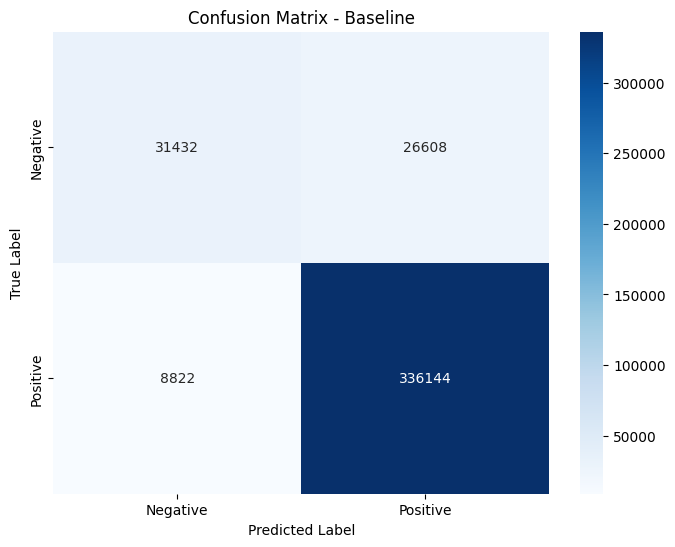

In [ ]:
# Confusion matrix for the baseline model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Baseline')
plt.show()

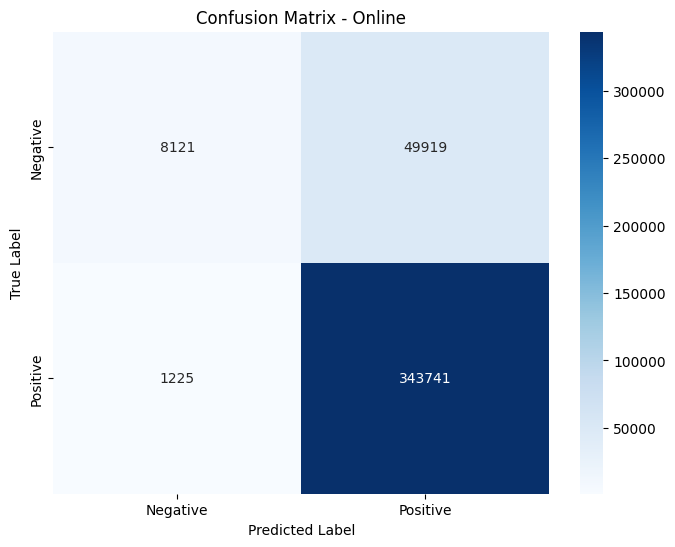

In [ ]:
# Confusion matrix for the online model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_online), annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Online')
plt.show()

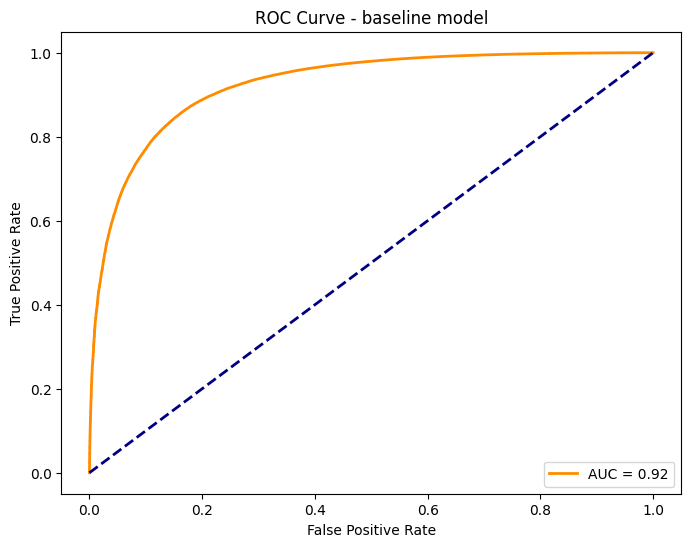

In [ ]:
y_prob = logreg_baseline_model.best_estimator_.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC - baseline model
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - baseline model')
plt.legend(loc='lower right')
plt.show()

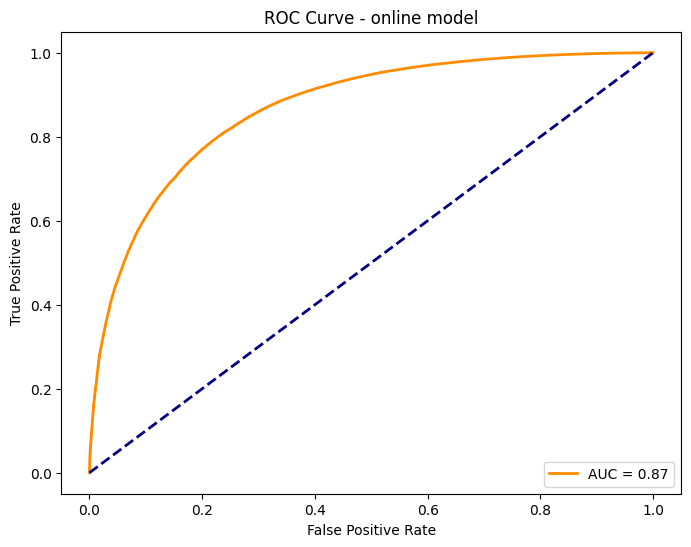

In [ ]:
y_prob_online = logreg_online_model.predict_proba(X_test_online)[:, 1]

# Compute ROC curve and AUC - online model
fpr, tpr, thresholds = roc_curve(y_test, y_prob_online)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - online model')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Some manual testing for fun
X_new = ['This is the best game I have ever played.', 'I hate this game.', 'This is the worst game I have ever played.', ':)', 'awful', 'very good', 'terrible']
X_new_online = vect.transform(X_new)

predictions = logreg_baseline_model.predict(X_new)
predictions_online = logreg_online_model.predict(X_new_online)

print('Predictions:', predictions)
print('Predictions (online):', predictions_online)

# There are also some strange (mis)classifications
X_new = [':(', 'very bad', 'very bad :(', 'terrible :(']
X_new_online = vect.transform(X_new)

predictions = logreg_baseline_model.predict(X_new)
predictions_online = logreg_online_model.predict(X_new_online)
print('\n')
print('Predictions:', predictions)
print('Predictions (online):', predictions_online)

Predictions: [1. 0. 0. 1. 0. 1. 0.]
Predictions (online): [1. 1. 0. 1. 0. 1. 0.]


Predictions: [1. 1. 1. 0.]
Predictions (online): [1. 0. 0. 0.]


In [ ]:
# Also a longer positive and negative review written by ChatGPT :)

positive_review = """I recently had the pleasure of playing the board game "Mystic Enchantments," and I must say it was an absolute delight from start to finish! This game seamlessly blends captivating theme, strategic depth, and engaging gameplay, making it a must-play for any board game enthusiast.

From the moment you open the beautifully illustrated box, you're transported into a world of mysticism and enchantment. The attention to detail in the artwork and components is stunning, creating a visually immersive experience that sets the stage for the adventure that lies ahead.

What sets "Mystic Enchantments" apart is its perfect balance of strategy and accessibility. The rules are intuitive, allowing new players to quickly grasp the mechanics, yet the game offers layers of strategic depth that keep seasoned players thoroughly engaged. The combination of resource management, clever card play, and unexpected twists keeps every turn exciting and unpredictable.

One of the standout features of the game is the diverse set of characters and enchantments, each with its unique abilities and strengths. This adds a wonderful element of replayability, as each game feels fresh and different based on the combinations of characters in play.

The pacing of "Mystic Enchantments" is spot-on, creating a sense of tension and excitement as players vie for control of mystical realms and magical artifacts. The game strikes that perfect balance where every decision matters, yet the outcome remains uncertain until the final moments, keeping everyone on the edge of their seats.

But perhaps what I appreciate most about this game is the social aspect it brings to the table. Whether you're strategizing with allies, negotiating deals, or plotting against your rivals, "Mystic Enchantments" fosters a lively and enjoyable gaming experience that extends beyond the board.

In conclusion, "Mystic Enchantments" is a triumph in the world of board gaming. It effortlessly combines a rich theme, strategic depth, and social interaction, creating an experience that will keep you coming back for more. I highly recommend this game to both casual players and seasoned gamers alike — it's a true gem in the world of tabletop entertainment!"""

negative_review = """I recently gave "Mystic Enchantments" a try, and unfortunately, my experience left much to be desired. Despite its visually appealing components and promising premise, the game fell short in several crucial aspects, resulting in a less-than-ideal gaming session.

To begin with, the rulebook proved to be more of a hindrance than a helpful guide. While attempting to grasp the game's mechanics, we found ourselves repeatedly flipping back and forth between pages, struggling to find clear explanations for certain concepts. The lack of clarity significantly impacted our initial enjoyment and added unnecessary confusion to what should have been a straightforward experience.

Once we managed to stumble through the rulebook, we encountered issues with the game's balance. Some characters and enchantments seemed disproportionately powerful, leading to frustratingly one-sided matches. This lack of equilibrium made strategic decision-making feel arbitrary at times, as certain players could gain insurmountable advantages early on.

Furthermore, the game's pacing left much to be desired. Rounds dragged on without a clear sense of progression, leading to a feeling of stagnation. While some complexity can be appreciated, "Mystic Enchantments" seemed to prioritize convolution over a streamlined and enjoyable gameplay experience.

The social dynamics promised by the game's design fell flat in execution. Instead of fostering engaging interactions, we often found ourselves bogged down by negotiations that felt forced and disconnected from the overall flow of the game. This led to a sense of detachment and a missed opportunity for the game to shine in the realm of player interaction.

While the thematic elements were visually appealing, they failed to enhance the overall experience. The enchanting world depicted in the artwork didn't translate into an equally enchanting gameplay experience. The disconnect between theme and mechanics left us feeling disconnected and disinterested in the unfolding narrative.

In conclusion, "Mystic Enchantments" presented a series of hurdles that hindered the enjoyment of what could have been a captivating board game. From unclear rules to imbalanced gameplay and a lackluster thematic integration, the overall experience left us wanting more. Unfortunately, the mystique promised by the title didn't translate into a magical gaming adventure, making it a difficult recommendation in its current state."""

very_negative_review = """"Chronicles of Despair" is an absolute disaster in the world of board games. From the moment you open the box, you're greeted with a sense of impending doom that never quite lifts throughout the gameplay experience. It's as if the designers set out to create a game that embodies the epitome of frustration and disappointment.

Firstly, let's talk about the rulebook – or lack thereof. The rulebook is a maze of contradictory statements, poorly explained mechanics, and ambiguities that leave players more confused than enlightened. It's almost as if the designers deliberately crafted it to be an insurmountable challenge to comprehend. Attempting to navigate the rulebook is an exercise in futility that sets the tone for the entire gaming experience.

The components of "Chronicles of Despair" are a cruel joke played on unsuspecting gamers. The cardboard pieces are flimsy and prone to tearing, the cards are of the lowest possible quality, and the game board looks like it was printed on a malfunctioning printer from the 1990s. It's as if the production team wanted to see how much they could cut corners without anyone noticing – spoiler alert, we noticed.

As for the gameplay itself, prepare for a descent into madness. The mechanics are convoluted, unbalanced, and seem to have been designed by someone with a vendetta against joy. The random events are more likely to punish players than provide any semblance of strategic depth, and the so-called "strategic decisions" are nothing more than a series of arbitrary choices that lead to inevitable disappointment.

The player interaction in "Chronicles of Despair" is more akin to a competitive exercise in frustration rather than an enjoyable social activity. The game actively discourages cooperation, turning every move into a cutthroat competition where alliances crumble faster than the hopes of winning.

In conclusion, "Chronicles of Despair" is an absolute train wreck of a board game. The designers seem to have taken pleasure in crafting an experience that leaves players questioning their life choices. Save yourself the agony and avoid this game at all costs – it's a black hole of fun that you'll never escape."""

In [ ]:
X_new = [positive_review, negative_review, very_negative_review]
X_new_online = vect.transform(X_new)

predictions = logreg_baseline_model.predict(X_new)
predictions_online = logreg_online_model.predict(X_new_online)

print('Predictions:', predictions)
print('Predictions (online):', predictions_online)

Predictions: [1. 0. 0.]
Predictions (online): [1. 1. 1.]


# Training models with upsampling of the negative class

As we can see above, the distribution of the negative and positive comments is not balanced and because of this the negative comment classification performs worse than the positive one.

Now, we try to duplicate rows for the negative comments to have more data on them and re-train the above models to compare the outcome.


In [ ]:
english_comments_df.head()

,rating,comment,name
0,1.0,i love the action selection in this and capita...,Puerto Rico
1,0.0,not a huge fan of marvel stuff fun very depend...,Hail Hydra
4,1.0,pure awesomeness this game is a pleasure to pl...,Navia Dratp
5,1.0,good but hard not quite as good as pandemic bu...,Ghost Stories
6,1.0,if you have the other 2 you have to get this o...,Dixit: Odyssey


In [ ]:
english_comments_df['rating'].value_counts()

1.0    1725396
0.0     289633
Name: rating, dtype: int64

In [ ]:
english_comments_df['rating'].value_counts(normalize=True)

1.0    0.856264
0.0    0.143736
Name: rating, dtype: float64

We upsample only the train negative class after the train_test_split, as we want to avoid data leakage from the test set into the training set to ensure that our model generalizes well on unseen data.

In [ ]:
# Split the data to train and test datasets
train_df, test_df = train_test_split(english_comments_df, test_size=0.2, random_state=0, stratify=english_comments_df['rating'])

positive_class = train_df[train_df['rating'] == 1]
negative_class = train_df[train_df['rating'] == 0]

negative_class_upsampled = resample(negative_class, replace=True, n_samples=len(positive_class), random_state=0)

np.random.seed(0)
train_upsampled = pd.concat([positive_class, negative_class_upsampled])
train_upsampled = train_upsampled.reset_index(drop=True)
train_upsampled = train_upsampled.reindex(np.random.permutation(train_upsampled.index))

X_train = train_upsampled['comment']
y_train = train_upsampled['rating']

X_test = test_df['comment']
y_test = test_df['rating']

In [ ]:
y_train.value_counts()

0.0    1380317
1.0    1380317
Name: rating, dtype: int64

In [ ]:
y_train.value_counts(normalize=True)

0.0    0.5
1.0    0.5
Name: rating, dtype: float64

In [ ]:
y_test.value_counts()

1.0    345079
0.0     57927
Name: rating, dtype: int64

In [ ]:
y_test.value_counts(normalize=True)

1.0    0.856263
0.0    0.143737
Name: rating, dtype: float64

In [ ]:
tfidf = TfidfVectorizer(strip_accents = None, lowercase = False, preprocessor = None)

small_param_grid = [{'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [None],
                     'vect__tokenizer': [tokenizer, tokenizer_porter],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]},
                    {'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [stop, None],
                     'vect__tokenizer': [tokenizer],
                     'vect__use_idf':[False],
                     'vect__smooth_idf':[False],
                     'vect__norm':[None],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]},]

lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, small_param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

In [ ]:
gs_lr_tfidf.fit(X_train, y_train)

# Save the model to a file
model_filename = "/content/drive/MyDrive/Mathematical Modeling Practice/logreg_baseline_upsampled.joblib"
dump(gs_lr_tfidf, model_filename)

print('\n')
print('Best parameter set:', gs_lr_tfidf.best_params_)
print('\n')
print('CV Accuracy:', gs_lr_tfidf.best_score_)
print('\n')
print('Test Accuracy:', gs_lr_tfidf.best_estimator_.score(X_test, y_test))


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Sadly, for the above code Google Colab disconnected after 12 hours. Even though I have a Colab Pro subscription, for increased computation time I would need a Google Colab Pro+ subscription that's just too expensive for me. Pro+ would allow the computations to run after a disconnect happens.

Another way would be to use a GPU, but for the above TfidfVectorizer and LogisticRegression it is not available.

In the future I would like to try to use Pytorch for this task.

Nevertheless, we can still train the online learning model with the new data, so at least we can compare that to the previous performance.

In [ ]:
# Create a HashingVectorizer and SGDClassifier to train the new model

vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer_online)

# SGDClassifier will use logistic regression
clf = SGDClassifier(loss='log_loss', random_state=1)

In [ ]:
batch_size = 10000
n_batches = int(np.ceil(len(X_train) / batch_size))

# To check progression of the training
progress_bar = tqdm(total=n_batches, desc='Training Progress')

# Train on mini-batches
for i in range(n_batches):
    progress_bar.update(1)

    start_index = min(i * batch_size, len(X_train))
    end_index = min((i + 1) * batch_size, len(X_train))

    X_batch = X_train.iloc[start_index:end_index]
    y_batch = y_train.iloc[start_index:end_index]

    # Transform text data using HashingVectorizer
    X_transformed = vect.transform(X_batch)

    # Partial fit the classifier
    clf.partial_fit(X_transformed, y_batch, classes=np.unique(y_train))

progress_bar.close()

# Save the model to a file
online_model_filename = "/content/drive/MyDrive/Mathematical Modeling Practice/logreg_online_upsampled.joblib"
dump(clf, online_model_filename)

X_test_online = vect.transform(X_test)
print('\nAccuracy:', clf.score(X_test_online, y_test))

Training Progress:   0%|          | 0/277 [00:00<?, ?it/s]


Accuracy: 0.7898343945251436


So that did not turn out very well... We've lost a big amount of accuracy compared to the previous model trained on imbalanced data. This is due to the fact that the starting data was highly imbalanced and the upsampling highly overfitted on the negative reviews as we took the length of the positive class elements. Also, the HashingVectorizer and SGDClassifier with the above minibatch implementation is dependent of the ordering of the training data and we don't actually run more epochs, only one full run-through on the data. We can also use a better approach for upsampling, like experimenting with the best ratios, so we try this out now, but after that, let's try out what happens if we do this the other way: undersampling of the majority class.

In [ ]:
# Split the data to train and test datasets
train_df, test_df = train_test_split(english_comments_df, test_size=0.2, random_state=0, stratify=english_comments_df['rating'])

positive_class = train_df[train_df['rating'] == 1]
negative_class = train_df[train_df['rating'] == 0]

print("\nSize of positive class:")
print(positive_class['rating'].value_counts())
print("\nSize of negative class:")
print(negative_class['rating'].value_counts())

# Use half the size of the positive_class
negative_class_upsampled = resample(negative_class, replace=True, n_samples=int(len(positive_class)*0.5), random_state=0)

np.random.seed(0)
train_upsampled = pd.concat([positive_class, negative_class_upsampled])
train_upsampled = train_upsampled.reset_index(drop=True)
train_upsampled = train_upsampled.reindex(np.random.permutation(train_upsampled.index))

print("\nSize train_upsampled:")
print(train_upsampled['rating'].value_counts())

X_train = train_upsampled['comment']
y_train = train_upsampled['rating']

X_test = test_df['comment']
y_test = test_df['rating']

# Create a HashingVectorizer and SGDClassifier to train the new model
vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer_online)

# SGDClassifier will use logistic regression
clf = SGDClassifier(loss='log_loss', random_state=1)

batch_size = 10000
n_batches = int(np.ceil(len(X_train) / batch_size))

# To check progression of the training
progress_bar = tqdm(total=n_batches, desc='Training Progress')

# Train on mini-batches
for i in range(n_batches):
    progress_bar.update(1)

    start_index = min(i * batch_size, len(X_train))
    end_index = min((i + 1) * batch_size, len(X_train))

    X_batch = X_train.iloc[start_index:end_index]
    y_batch = y_train.iloc[start_index:end_index]

    # Transform text data using HashingVectorizer
    X_transformed = vect.transform(X_batch)

    # Partial fit the classifier
    clf.partial_fit(X_transformed, y_batch, classes=np.unique(y_train))

progress_bar.close()

# Save the model to a file
online_model_filename = "/content/drive/MyDrive/Mathematical Modeling Practice/logreg_online_upsampled_half_positive_size.joblib"
dump(clf, online_model_filename)

X_test_online = vect.transform(X_test)
print('\nAccuracy:', clf.score(X_test_online, y_test))


Size of positive class:
1.0    1380317
Name: rating, dtype: int64

Size of negative class:
0.0    231706
Name: rating, dtype: int64

Size train_upsampled:
1.0    1380317
0.0     690158
Name: rating, dtype: int64


Training Progress:   0%|          | 0/208 [00:00<?, ?it/s]


Accuracy: 0.8825823933142435


In [ ]:
# Split the data to train and test datasets
train_df, test_df = train_test_split(english_comments_df, test_size=0.2, random_state=0, stratify=english_comments_df['rating'])

positive_class = train_df[train_df['rating'] == 1]
negative_class = train_df[train_df['rating'] == 0]

print("\nSize of positive class:")
print(positive_class['rating'].value_counts())
print("\nSize of negative class:")
print(negative_class['rating'].value_counts())

# Use double the size of the negative_class
negative_class_upsampled = resample(negative_class, replace=True, n_samples=int(len(negative_class)*2), random_state=0)

np.random.seed(0)
train_upsampled = pd.concat([positive_class, negative_class_upsampled])
train_upsampled = train_upsampled.reset_index(drop=True)
train_upsampled = train_upsampled.reindex(np.random.permutation(train_upsampled.index))

print("\nSize train_upsampled:")
print(train_upsampled['rating'].value_counts())

X_train = train_upsampled['comment']
y_train = train_upsampled['rating']

X_test = test_df['comment']
y_test = test_df['rating']

# Create a HashingVectorizer and SGDClassifier to train the new model
vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer_online)

# SGDClassifier will use logistic regression
clf = SGDClassifier(loss='log_loss', random_state=1)

batch_size = 10000
n_batches = int(np.ceil(len(X_train) / batch_size))

# To check progression of the training
progress_bar = tqdm(total=n_batches, desc='Training Progress')

# Train on mini-batches
for i in range(n_batches):
    progress_bar.update(1)

    start_index = min(i * batch_size, len(X_train))
    end_index = min((i + 1) * batch_size, len(X_train))

    X_batch = X_train.iloc[start_index:end_index]
    y_batch = y_train.iloc[start_index:end_index]

    # Transform text data using HashingVectorizer
    X_transformed = vect.transform(X_batch)

    # Partial fit the classifier
    clf.partial_fit(X_transformed, y_batch, classes=np.unique(y_train))

progress_bar.close()

# Save the model to a file
online_model_filename = "/content/drive/MyDrive/Mathematical Modeling Practice/logreg_online_upsampled_double_negative_size.joblib"
dump(clf, online_model_filename)

X_test_online = vect.transform(X_test)
print('\nAccuracy:', clf.score(X_test_online, y_test))


Size of positive class:
1.0    1380317
Name: rating, dtype: int64

Size of negative class:
0.0    231706
Name: rating, dtype: int64

Size train_upsampled:
1.0    1380317
0.0     463412
Name: rating, dtype: int64


Training Progress:   0%|          | 0/185 [00:00<?, ?it/s]


Accuracy: 0.8895500315131785


Now, it looks promising, even with using double the size of the negative class for upsampling, we increased the performance compared to the original model by 1.4%.

We should try to use this approach to the baseline model, so maybe the learning time won't increase that much.

In [ ]:
# Split the data to train and test datasets
train_df, test_df = train_test_split(english_comments_df, test_size=0.2, random_state=0, stratify=english_comments_df['rating'])

positive_class = train_df[train_df['rating'] == 1]
negative_class = train_df[train_df['rating'] == 0]

# Use double the size of the negative_class
negative_class_upsampled = resample(negative_class, replace=True, n_samples=int(len(negative_class)*2), random_state=0)

np.random.seed(0)
train_upsampled = pd.concat([positive_class, negative_class_upsampled])
train_upsampled = train_upsampled.reset_index(drop=True)
train_upsampled = train_upsampled.reindex(np.random.permutation(train_upsampled.index))

X_train = train_upsampled['comment']
y_train = train_upsampled['rating']

X_test = test_df['comment']
y_test = test_df['rating']

tfidf = TfidfVectorizer(strip_accents = None, lowercase = False, preprocessor = None)

small_param_grid = [{'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [None],
                     'vect__tokenizer': [tokenizer, tokenizer_porter],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]},
                    {'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [stop, None],
                     'vect__tokenizer': [tokenizer],
                     'vect__use_idf':[False],
                     'vect__smooth_idf':[False],
                     'vect__norm':[None],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]},]

lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, small_param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

# Save the model to a file
model_filename = "/content/drive/MyDrive/Mathematical Modeling Practice/logreg_baseline_upsampled_double_negative_size.joblib"
dump(gs_lr_tfidf, model_filename)

print('\n')
print('Best parameter set:', gs_lr_tfidf.best_params_)
print('\n')
print('CV Accuracy:', gs_lr_tfidf.best_score_)
print('\n')
print('Test Accuracy:', gs_lr_tfidf.best_estimator_.score(X_test, y_test))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7a807a2cd360>}


CV Accuracy: 0.8869920689029687


Test Accuracy: 0.9038699175694654


In [ ]:
# Classification report for the baseline model
y_pred = gs_lr_tfidf.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.67      0.67     57927
         1.0       0.94      0.94      0.94    345079

    accuracy                           0.90    403006
   macro avg       0.80      0.81      0.81    403006
weighted avg       0.90      0.90      0.90    403006



For comparison these were the values of the baseline model:

                   precision  recall  f1-score   support

         0.0       0.78       0.54      0.64     58040
         1.0       0.93       0.97      0.95    344966

     accuracy                           0.91    403006
     macro avg     0.85       0.76      0.79    403006
     weighted avg  0.91       0.91      0.91    403006

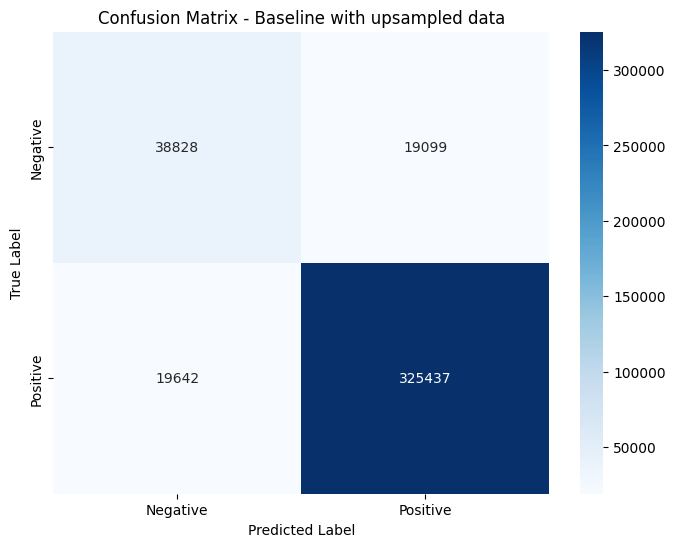

In [ ]:
# Confusion matrix for the baseline model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Baseline with upsampled data')
plt.show()

It was the confusion matrix of the baseline model:

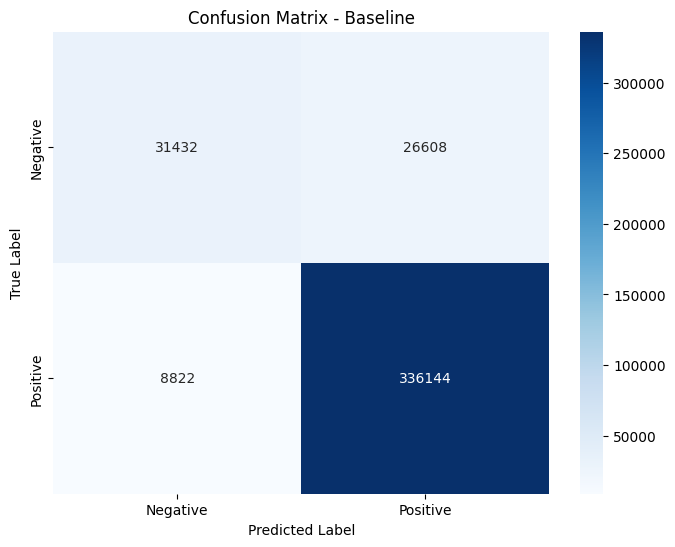

We can see that the new model performed better on classifying the negative comments, but we also lost some precision on classifying the positive ones.

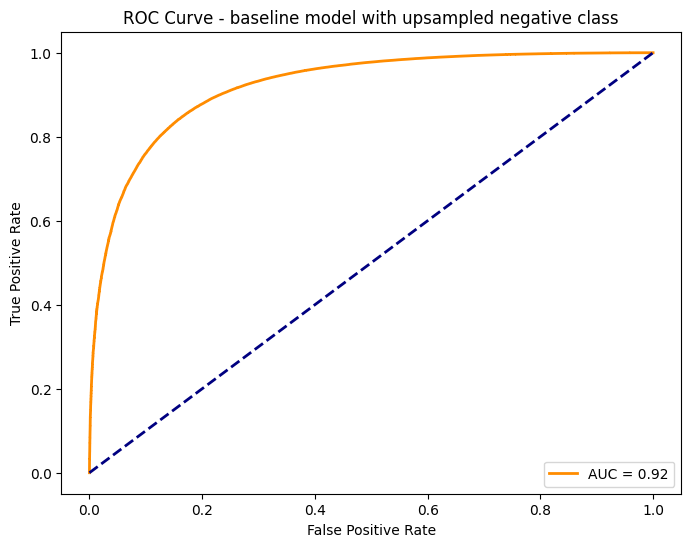

In [ ]:
y_prob = gs_lr_tfidf.best_estimator_.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC - baseline model with upsampled negative class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - baseline model with upsampled negative class')
plt.legend(loc='lower right')
plt.show()

Let's see if it performs better on the manual tests.

In [ ]:
X_new = ['This is the best game I have ever played.', 'I hate this game.', 'This is the worst game I have ever played.', ':)', 'awful', 'very good', 'terrible']

predictions = gs_lr_tfidf.best_estimator_.predict(X_new)

print('Predictions:', predictions)

X_new = [':(', 'very bad', 'very bad :(', 'terrible :(']

predictions = gs_lr_tfidf.best_estimator_.predict(X_new)
print('\n')
print('Predictions:', predictions)

Predictions: [1. 0. 0. 1. 0. 1. 0.]


Predictions: [1. 1. 1. 0.]


It is still the same. Maybe these values are not present in the training dataset or the weight for them remained mostly the same.

In [ ]:
X_new = [positive_review, negative_review, very_negative_review]

predictions = gs_lr_tfidf.best_estimator_.predict(X_new)

print('Predictions:', predictions)

Predictions: [1. 0. 0.]


# Training models with downsampling of the positive class

In [ ]:
english_comments_df.head()

,rating,comment,name
0,1.0,i love the action selection in this and capita...,Puerto Rico
1,0.0,not a huge fan of marvel stuff fun very depend...,Hail Hydra
4,1.0,pure awesomeness this game is a pleasure to pl...,Navia Dratp
5,1.0,good but hard not quite as good as pandemic bu...,Ghost Stories
6,1.0,if you have the other 2 you have to get this o...,Dixit: Odyssey


In [ ]:
english_comments_df['rating'].value_counts()

1.0    1725396
0.0     289633
Name: rating, dtype: int64

In [ ]:
english_comments_df['rating'].value_counts(normalize=True)

1.0    0.856264
0.0    0.143736
Name: rating, dtype: float64

In [ ]:
# Split the data to train and test datasets
train_df, test_df = train_test_split(english_comments_df, test_size=0.2, random_state=0, stratify=english_comments_df['rating'])

positive_class = train_df[train_df['rating'] == 1]
negative_class = train_df[train_df['rating'] == 0]

positive_class_downsampled = resample(positive_class, replace=False, n_samples=len(negative_class), random_state=0)

train_downsampled = pd.concat([positive_class_downsampled, negative_class])

np.random.seed(0)
train_downsampled = train_downsampled.reindex(np.random.permutation(train_downsampled.index))

X_train = train_downsampled['comment']
y_train = train_downsampled['rating']

X_test = test_df['comment']
y_test = test_df['rating']

In [ ]:
y_train.value_counts()

1.0    231706
0.0    231706
Name: rating, dtype: int64

In [ ]:
y_train.value_counts(normalize=True)

1.0    0.5
0.0    0.5
Name: rating, dtype: float64

In [ ]:
y_test.value_counts()

1.0    345079
0.0     57927
Name: rating, dtype: int64

In [ ]:
y_test.value_counts(normalize=True)

1.0    0.856263
0.0    0.143737
Name: rating, dtype: float64

In [ ]:
# Re-initialize the TfidfVectorizer and the pipeline to train the new model
negative_class_upsampled = resample(negative_class, replace=True, n_samples=len(negative_class), random_state=0)

tfidf = TfidfVectorizer(strip_accents = None, lowercase = False, preprocessor = None)

small_param_grid = [{'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [None],
                     'vect__tokenizer': [tokenizer, tokenizer_porter],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]},
                    {'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [stop, None],
                     'vect__tokenizer': [tokenizer],
                     'vect__use_idf':[False],
                     'vect__smooth_idf':[False],
                     'vect__norm':[None],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]},]

lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression(solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, small_param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

In [ ]:
gs_lr_tfidf.fit(X_train, y_train)

# Save the model to a file
model_filename = "/content/drive/MyDrive/Mathematical Modeling Practice/logreg_baseline_downsampled.joblib"
dump(gs_lr_tfidf, model_filename)

print('\n')
print('Best parameter set:', gs_lr_tfidf.best_params_)
print('\n')
print('CV Accuracy:', gs_lr_tfidf.best_score_)
print('\n')
print('Test Accuracy:', gs_lr_tfidf.best_estimator_.score(X_test, y_test))


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(




Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7a807a2cd360>}


CV Accuracy: 0.8440523769658697


Test Accuracy: 0.8464141973072361


In [ ]:
# Re-initialize the HashingVectorizer and SGDClassifier to train the new model

vect = HashingVectorizer(decode_error='ignore', n_features=2**21, preprocessor=None, tokenizer=tokenizer_online)

# SGDClassifier will use logistic regression
clf = SGDClassifier(loss='log_loss', random_state=1)

In [ ]:
batch_size = 10000
n_batches = int(np.ceil(len(X_train) / batch_size))

# To check progression of the training
progress_bar = tqdm(total=n_batches, desc='Training Progress')

# Train on mini-batches
for i in range(n_batches):
    progress_bar.update(1)

    start_index = min(i * batch_size, len(X_train))
    end_index = min((i + 1) * batch_size, len(X_train))

    X_batch = X_train.iloc[start_index:end_index]
    y_batch = y_train.iloc[start_index:end_index]

    # Transform text data using HashingVectorizer
    X_transformed = vect.transform(X_batch)

    # Partial fit the classifier
    clf.partial_fit(X_transformed, y_batch, classes=np.unique(y_train))

progress_bar.close()

# Save the model to a file
online_model_filename = "/content/drive/MyDrive/Mathematical Modeling Practice/logreg_online_downsampled.joblib"
dump(clf, online_model_filename)

X_test_online = vect.transform(X_test)
print('\nAccuracy:', clf.score(X_test_online, y_test))


Training Progress:   0%|          | 0/47 [00:00<?, ?it/s]


Accuracy: 0.783469725016501


With the downsampling approach we've lost considerate precision compared to the baseline models or even to the upsampling case. Nevertheless, let's look at them in more detail.

In [ ]:
from joblib import load

# Load the models from the file
logreg_baseline_model = load('/content/drive/MyDrive/Mathematical Modeling Practice/logreg_baseline_downsampled.joblib')
logreg_online_model = load('/content/drive/MyDrive/Mathematical Modeling Practice/logreg_online_downsampled.joblib')

In [ ]:
# Classification report for the baseline model with downsampled positive class
y_pred = logreg_baseline_model.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.48      0.84      0.61     57927
         1.0       0.97      0.85      0.90    345079

    accuracy                           0.85    403006
   macro avg       0.73      0.84      0.76    403006
weighted avg       0.90      0.85      0.86    403006



In [ ]:
# Classification report for the online model with downsampled positive class
X_test_online = vect.transform(X_test)
y_pred_online = logreg_online_model.predict(X_test_online)

print(classification_report(y_test, y_pred_online))

              precision    recall  f1-score   support

         0.0       0.38      0.81      0.52     57927
         1.0       0.96      0.78      0.86    345079

    accuracy                           0.78    403006
   macro avg       0.67      0.79      0.69    403006
weighted avg       0.88      0.78      0.81    403006



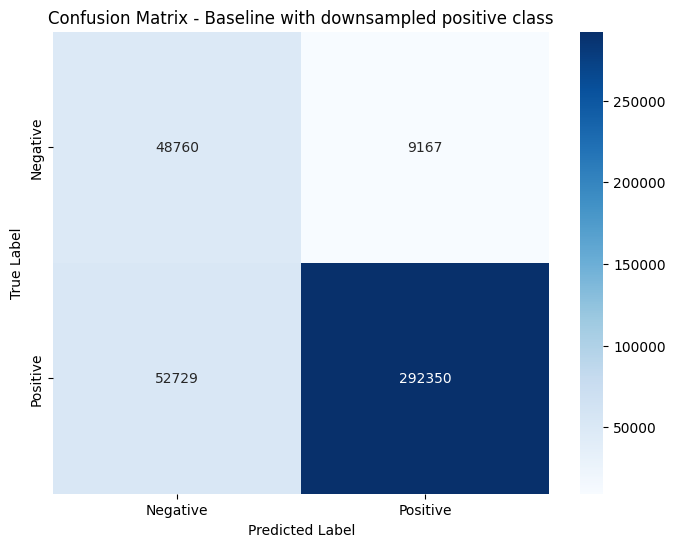

In [ ]:
# Confusion matrix for the baseline model with downsampled positive class
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Baseline with downsampled positive class')
plt.show()

This confusion matrix is almost the opposite of the upsampled one: we can predict the true negative label better, but lost a great amount of precision on predicting the true positive ones.

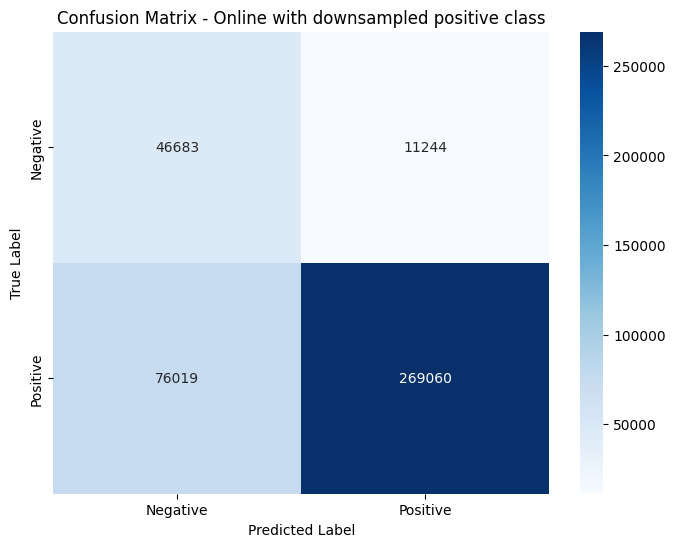

In [ ]:
# Confusion matrix for the online model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_online), annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Online with downsampled positive class')
plt.show()

# Conclusion and further research questions

Overall, our first model performed well apart from some strange misclassification errors that might be because of the available amount of "negative" ratings.

Here are some important questions that would also be worth investigating:

Metrics:
- Collect ideas for metrics to compare different models.
- Create a framework for model evaluation that capable of running and comparing multiple models.

Ratings:
- We have converted the ratings to integer numbers, but what happens if we leave them as doubles and try to fit some regressions on them?
- Also, should we scale the rating numbers?
- How could we compare 2 models trained on integers and on doubles? Metric?

Plotting:
- It would also be great if we could create more plots with different scales/zooms for better visualization. (Filter in Pandas for example for values < 1000 etc.)

Languages:
- As for now we only trained a model on English comments. Train on different languages and compare performance?

Evaluation idea:
- Currently, a board game's title could appear in a comment, for example, when comparing two different games. This way, a title that got higher ratings is also part of the training data. Could this have any effect on the performance?
During a test, replace the name of the board game with "Unknown" in the test data and evaluate the performance also that way.

Models:
- As for now we only have 2 models for binary classification. Also train more models for classification that assigns numbers from 1-10 to reviews.
- A promising one would be with neural networks.

Misclassifications:
- There are some strange misclassification errors, such as ':(' being classified as positive. We should improve the performance on these.

Distibution of ratings:
- Currently there is a great imbalance between the amount of positive and negative ratings. We should also try to fix this with some approaches, e.g. using a better upscaling method that generates synthetic data instead of the resample method we've used above.

Reindexing bug:
- The reindexing bug that introduced 5 NaNs into the comments must be fixed.